# Лабораторная работа №1

**Выполнил**: Подцепко Игорь, M4138.

In [14]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time

from typing import Callable
from torch.utils.data import TensorDataset, DataLoader, random_split

## Генерация данных

По заданию требуется сгенерировать три случайных *нелинейных* регрессии. Для удобства реализуем метод `generate_dataset`, который будет принимать математическую функцию двух переменных и генерировать объект класса `torch.utils.data.TensorDataset` для тренировочной и тестовой частей.

In [15]:
torch.manual_seed(42)


def generate_regression(
    function: Callable[[torch.FloatTensor, torch.FloatTensor], torch.FloatTensor],
    n_samples: int,
):
    x1 = torch.rand(n_samples) * 4 - 2
    x2 = torch.rand(n_samples) * 4 - 2
    y = function(x1, x2) + torch.randn(n_samples) * 0.1
    return torch.stack([x1, x2], dim=1), y.view(-1, 1)


def generate_dataset(
    regression: Callable[[torch.FloatTensor, torch.FloatTensor], torch.FloatTensor],
    label: str,
    n_samples: int = 2**12,
):
    X, y = generate_regression(regression, n_samples)

    train_size = int(0.9 * n_samples)
    test_size = n_samples - train_size

    X_train, X_test = random_split(X, [train_size, test_size])
    y_train, y_test = random_split(y, [train_size, test_size])

    train_dataset = TensorDataset(
        X_train.dataset[X_train.indices], y_train.dataset[y_train.indices]
    )
    test_dataset = TensorDataset(
        X_test.dataset[X_test.indices], y_test.dataset[y_test.indices]
    )

    return {"train": train_dataset, "test": test_dataset, "label": label}

Реализуем следующие нелинейные функции:
1. $f(x_1, x_2) = 2x_1^2 + 3x_2$
2. $f(x_1, x_2) = \sin(x_1) + \log(x_2^2 + 1)$
3. $f(x_1, x_2) = e^{x_1} - x_2^3 + x_1 + x_2$

К каждой изних будет добавлен небольшой шум.

In [16]:
datasets = [
    generate_dataset(
        lambda x1, x2: 2 * x1**2 + 3 * x2, label="$f(x_1, x_2) = 2x_1^2 + 3x_2$"
    ),
    generate_dataset(
        lambda x1, x2: torch.sin(x1) + torch.log(x2**2 + 1),
        label="$f(x_1, x_2) = \\sin(x_1) + \\log(x_2^2 + 1)$",
    ),
    generate_dataset(
        lambda x1, x2: torch.exp(x1) - x2**3 + x1 * x2,
        label="$f(x_1, x_2) = e^{x_1} - x_2^3 + x_1 + x_2$",
    ),
]

## Архитектура модели

Для обучения реализуем линейную модель с тремя скрытыми слоями:

In [17]:
class Model(nn.Module):
    def __init__(
        self,
        use_batch_norm: bool = False,
        use_dropout: bool = False,
        p_dropout: float = 0.5,
    ):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            Model._make_layer(2, 64, use_batch_norm, use_dropout, p_dropout),
            Model._make_layer(64, 128, use_batch_norm, use_dropout, p_dropout),
            Model._make_layer(128, 64, use_batch_norm, use_dropout, p_dropout),
            Model._make_layer(64, 1),
        )

    @staticmethod
    def _make_layer(
        in_features: int,
        out_features: int,
        use_batch_norm: bool = False,
        use_dropout: bool = False,
        p_dropout: float = 0.5,
    ):
        layers = []
        layers.append(nn.Linear(in_features, out_features))
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(out_features))
        layers.append(nn.ReLU())
        if use_dropout:
            layers.append(nn.Dropout(p=p_dropout))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## 1. Сравнение разных размеров батча

In [18]:
batch_sizes = [64, 128, 256]

In [19]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [20]:
def train_model(dataset, model, batch_size, n_epochs=250, lr=1e-2):
    model.to(device)

    train_loader = DataLoader(dataset["train"], batch_size=batch_size)
    test_loader = DataLoader(dataset["test"], batch_size=batch_size)

    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    model.train()
    for _ in range(n_epochs):
        epoch_loss = 0.0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)

        losses.append(epoch_loss)

    model.eval()
    test_loss = 0.0

    with torch.inference_mode():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()

    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    return losses

In [21]:
def show_plots(title):
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

Train with batch_size=64 on $f(x_1, x_2) = 2x_1^2 + 3x_2$
Test Loss: 18.9066
Elapsed: 84.14034485816956
Train with batch_size=128 on $f(x_1, x_2) = 2x_1^2 + 3x_2$
Test Loss: 17.9035
Elapsed: 40.10534381866455
Train with batch_size=256 on $f(x_1, x_2) = 2x_1^2 + 3x_2$
Test Loss: 18.4213
Elapsed: 22.814738988876343


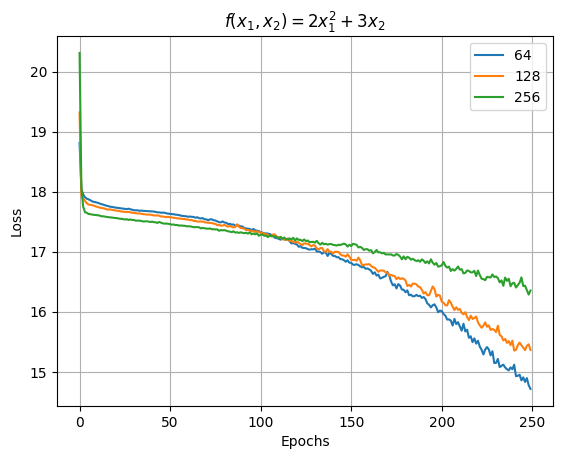

Train with batch_size=64 on $f(x_1, x_2) = \sin(x_1) + \log(x_2^2 + 1)$
Test Loss: 0.8784
Elapsed: 78.43356990814209
Train with batch_size=128 on $f(x_1, x_2) = \sin(x_1) + \log(x_2^2 + 1)$
Test Loss: 0.8328
Elapsed: 42.88972592353821
Train with batch_size=256 on $f(x_1, x_2) = \sin(x_1) + \log(x_2^2 + 1)$
Test Loss: 0.8009
Elapsed: 23.585867166519165


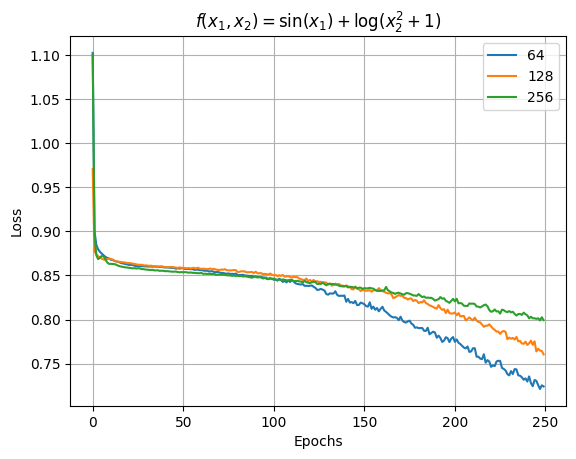

Train with batch_size=64 on $f(x_1, x_2) = e^{x_1} - x_2^3 + x_1 + x_2$
Test Loss: 16.3118
Elapsed: 81.84881091117859
Train with batch_size=128 on $f(x_1, x_2) = e^{x_1} - x_2^3 + x_1 + x_2$
Test Loss: 16.3088
Elapsed: 40.33910918235779
Train with batch_size=256 on $f(x_1, x_2) = e^{x_1} - x_2^3 + x_1 + x_2$
Test Loss: 16.0524
Elapsed: 22.879251956939697


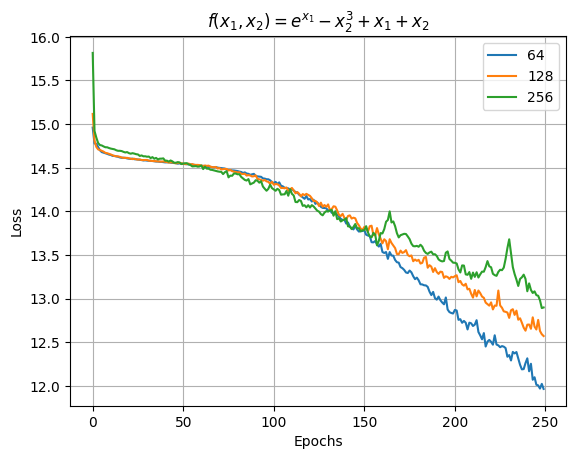

In [22]:
for dataset in datasets:
    for batch_size in batch_sizes:
        print(f"Train with batch_size={batch_size} on {dataset['label']}")
        model = Model(use_batch_norm=True)
        start_time = time.time()
        losses = train_model(dataset, model, batch_size)
        elapsed = time.time() - start_time
        print(f"Elapsed: {elapsed}")
        plt.plot(losses, label=batch_size)
    show_plots(dataset["label"])

Несмотря на то, что на тренировочных данных ошибка при размере батча 256 во всех трех экспериментах оказалась наибольшей, на тестовых данных:
- В двух случаях наименьшая ошибка была при использовании батча размером 256
- В одном случае — при размере батча 128

Таким образом, в качестве лучшего значения выбираем 256.

In [23]:
best_batch_size = 256

## 2. Анализ дропаута

Train without BatchNorm, without Dropout
Test Loss: 18.6273
Train without BatchNorm, with Dropout
Test Loss: 18.0738
Train with BatchNorm, without Dropout
Test Loss: 18.8665
Train with BatchNorm, with Dropout
Test Loss: 18.0210


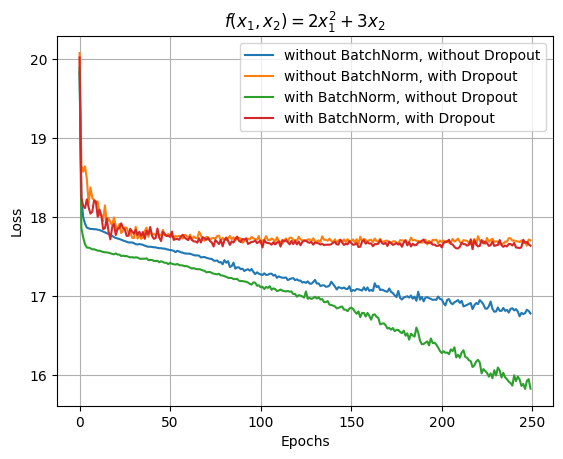

Train without BatchNorm, without Dropout
Test Loss: 0.7602
Train without BatchNorm, with Dropout
Test Loss: 0.7230
Train with BatchNorm, without Dropout
Test Loss: 0.7846
Train with BatchNorm, with Dropout
Test Loss: 0.7263


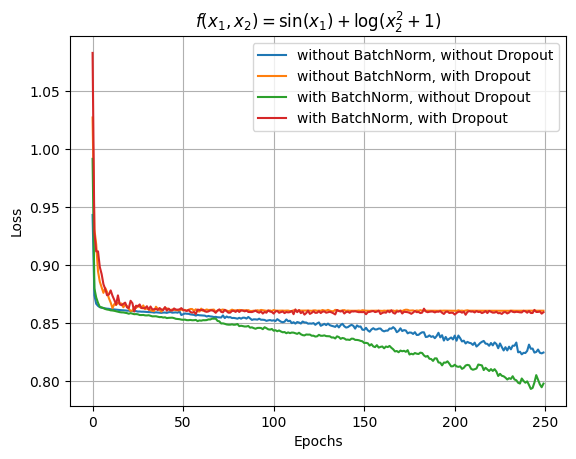

Train without BatchNorm, without Dropout
Test Loss: 16.1313
Train without BatchNorm, with Dropout
Test Loss: 14.7026
Train with BatchNorm, without Dropout
Test Loss: 16.0103
Train with BatchNorm, with Dropout
Test Loss: 14.7344


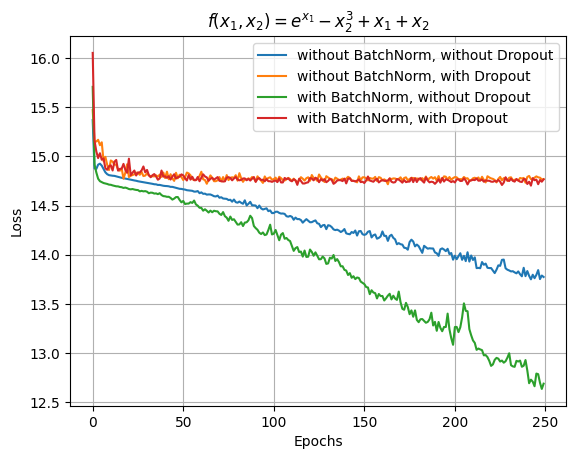

In [24]:
def make_label(use_batch_norm: bool, use_dropout: bool):
    impl = lambda x: "with" if x else "without"
    return f"{impl(use_batch_norm)} BatchNorm, {impl(use_dropout)} Dropout"


for dataset in datasets:
    for use_batch_norm in False, True:
        for use_dropout in False, True:
            label = make_label(use_batch_norm, use_dropout)
            print(f"Train {label}")
            model = Model(use_batch_norm=use_batch_norm, use_dropout=use_dropout)
            losses = train_model(dataset, model, best_batch_size)
            plt.plot(losses, label=label)
    show_plots(dataset["label"])

## Выводы

1. Результаты экспериментов подтверждают утверждение о том, что размер батча лучше выбирать наибольший, какой помещается в памяти. Чем больше размер батча, тем:
   1. Быстрее происходит обучение благодаря возможности выполнять больше операций параллельно;
   2. Ниже вероятность переобучения из-за более точного подсчета характеристик распределения входов нейронов.
2. Дропаут позволяет достаточно эффективно бороться с переобучением. Результаты на тестовой части набора данных оказываются лучше, чем без использования дропаута, при этом при использовании нормализации явно видно, что происходит переобучение.
3. Только для первой регрессии совместное использование дропаута и нормализации дает наилучший результат, в остальных двух случаях это не является эффективным.
4. Обучение с использованием дропаута происходит медленнее.